# Difc calculation using scipy


In [1]:
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
import os, numpy as np
from mantid import simpleapi as msa, mtd

In [3]:
dvalues = [1.10860231, 1.24596143, 1.357755, 1.63751414, 1.92015553, 3.13560085]

In [4]:
%%time
ws = msa.Load('/SNS/SEQ/IPTS-19573/nexus/SEQ_130273.nxs.h5')

CPU times: user 1min 1s, sys: 16.4 s, total: 1min 18s
Wall time: 15.8 s


In [5]:
%%time
ws = msa.CropWorkspace(InputWorkspace=ws, XMin=300, XMax=16666.7)

CPU times: user 3min 42s, sys: 2min 59s, total: 6min 42s
Wall time: 26.5 s


## Compute nominal difc

In [6]:
difc = msa.CalculateDIFC(InputWorkspace=ws)

In [7]:
difc = difc.extractY().flatten()

# Use nominal values to convert to I(d)

In [8]:
%%time
I_d = msa.ConvertUnits(InputWorkspace=ws, Target='dSpacing', EMode='Elastic')

CPU times: user 10.2 s, sys: 8.69 s, total: 18.9 s
Wall time: 18.9 s


In [49]:
%%time
I_d = msa.Rebin(InputWorkspace=I_d, Params='0.4,0.005,7')

CPU times: user 104 ms, sys: 72 ms, total: 176 ms
Wall time: 171 ms


# Get pack index

In [ ]:
instrument = ws.getInstrument()

In [ ]:
pack = instrument.getComponentByName("B9/eightpack")

In [ ]:
firstpixel = pack[0][0].getID()
firstpixel

In [ ]:
lasttube = pack[pack.nelements()-1]
lastpixel = lasttube[lasttube.nelements()-1]
lastpixel = lastpixel.getID()
lastpixel

In [ ]:
detIDs = []
for i in range(ws.getNumberHistograms()):
    sp = ws.getSpectrum(i)
    dets = list(sp.getDetectorIDs())
    assert len(dets)==1
    detIDs.append(dets[0])
    continue

In [ ]:
for i in range(len(detIDs)-1):
    assert detIDs[i] < detIDs[i+1]

In [ ]:
startindex = detIDs.index(firstpixel)
endindex = detIDs.index(lastpixel)
startindex, endindex

In [10]:
I_d_B9 = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=8192, EndWorkspaceIndex=9215)

<IPython.core.display.Javascript object>


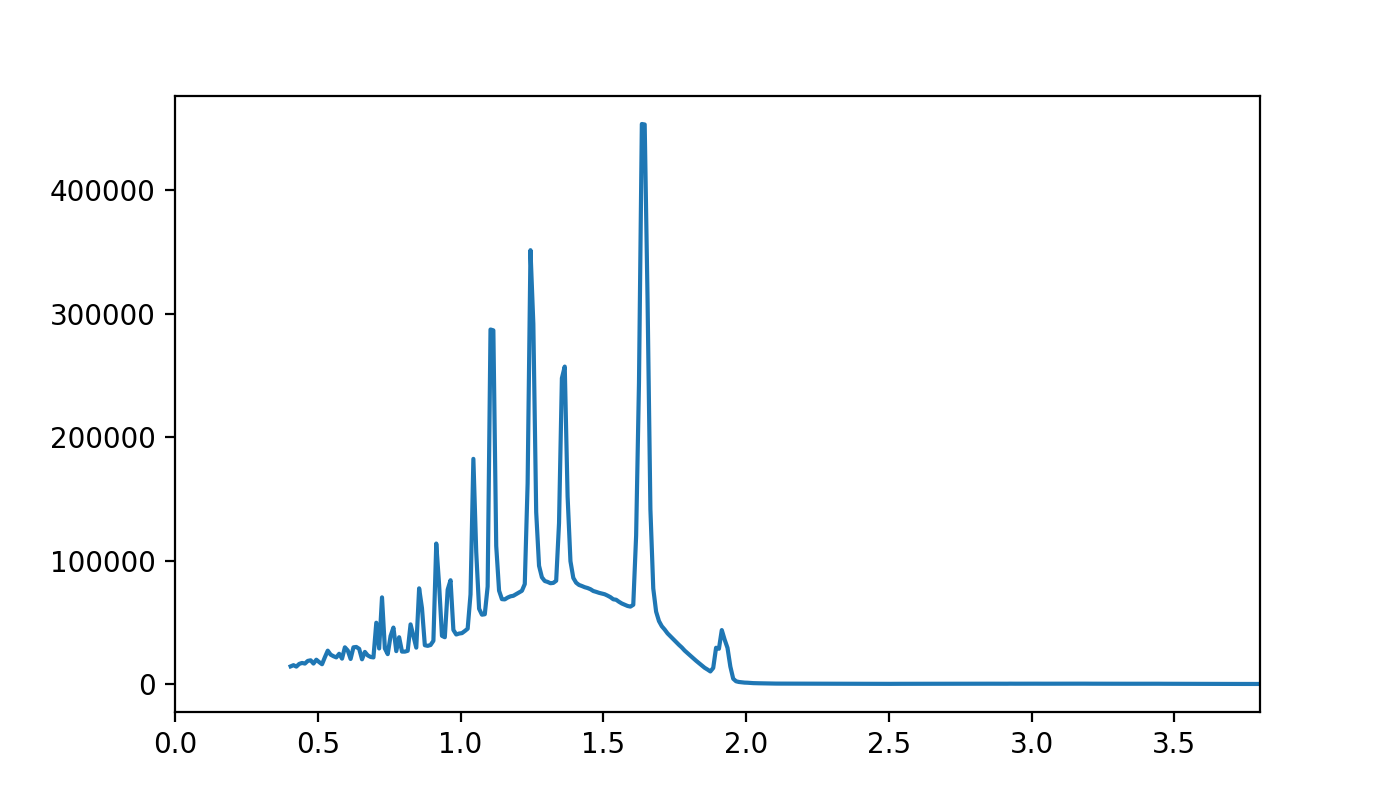

(0, 3.8)

In [87]:
plt.figure(figsize=(7,4))
Xbb = I_d_B9.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_B9.readY(0))
plt.xlim(0,3.8)

In [53]:
I_d_pixel = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=8242, EndWorkspaceIndex=8242)

<IPython.core.display.Javascript object>


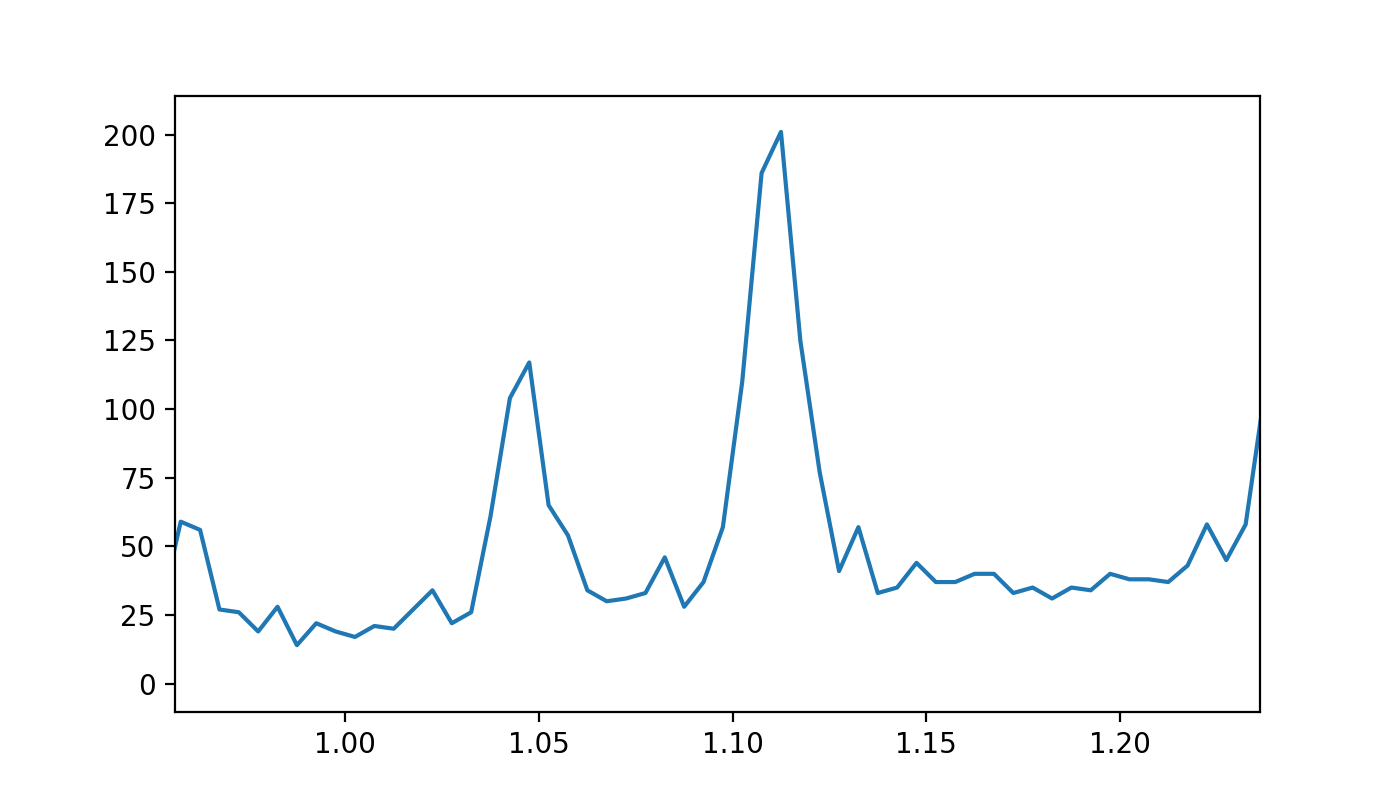

(0, 3.8)

In [54]:
plt.figure(figsize=(7,4))
Xbb = I_d_pixel.readX(0)
plt.plot( (Xbb[:-1]+Xbb[1:])/2, I_d_pixel.readY(0))
plt.xlim(0,3.8)

Simple fitting

In [23]:
import scipy.optimize as sopt

In [25]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [26]:
def gauss_with_bg(x, *p):
    A, mu, sigma, bg = p
    return bg + A*np.exp(-(x-mu)**2/(2.*sigma**2))

In [ ]:
x = (Xbb[:-1]+Xbb[1:])/2
y = I_d_100455.readY(0)

In [ ]:
np.where(x>3)[0][0], np.where(x<3.3)[0][-1]

In [ ]:
x1 = x[260:289]
y1 = y[260:289]

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(x1,y1)

In [ ]:
popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=(400, 3.13, 0.05, 0))
print popt

obsolete
```
def cost(p):
    y1_model = gauss(x1, *p)
    return np.sum( (y1-y1_model)**2 )

optres = sopt.minimize(cost, x0=(400, 3.13, 0.05))

optres.x
```

In [ ]:
plt.figure(figsize=(5,3))
plt.errorbar(x1, y1, yerr=np.sqrt(y1))
plt.plot(x1, gauss_with_bg(x1, *popt))

goodness of fit?

In [ ]:
chisq = np.average((y1 - gauss_with_bg(x1, *popt))**2 / y1)

In [ ]:
chisq

In [ ]:
difc[100455]

new difc

In [ ]:
difc[100455]*optres.x[1]/3.13560085

## Loop over all pixels in B9

In [14]:
N = I_d.getNumberHistograms()

In [15]:
newdifc = difc.copy()

In [19]:
maxchisq = 3.

In [30]:
mask = np.zeros(difc.shape, dtype=bool)
chisq = np.zeros((len(dvalues),) + difc.shape, dtype=float)
peaks = np.zeros((len(dvalues),) + difc.shape, dtype=float)

In [57]:
firstindex = 8192
lastindex = 9215

In [71]:
%%time

for pixel in range(firstindex, lastindex+1):
# for pixel in range(firstindex+50, firstindex+51):
    if (pixel%100)==0 : print pixel
    # print pixel
    I_d_pixel = msa.SumSpectra(InputWorkspace=I_d, StartWorkspaceIndex=pixel, EndWorkspaceIndex=pixel)
    Xbb = I_d_pixel.readX(0)
    x = (Xbb[:-1]+Xbb[1:])/2
    y = I_d_pixel.readY(0)
    peaks_thispixel = peaks[:, pixel]
    for pkindex, d0 in enumerate(dvalues):
        dmin = d0*.96
        dmax = d0*1.04
        startindex, stopindex = np.where(x>dmin)[0][0], np.where(x<dmax)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        # print x1
        # print y1
        guess_center = x1[np.argmax(y1)]
        startindex, stopindex = np.where(x>guess_center-0.05*d0)[0][0], np.where(x<guess_center+0.05*d0)[0][-1]
        x1 = x[startindex:stopindex]
        y1 = y[startindex:stopindex]
        bg = (y1[0]+y1[-1])/2
        p0 = np.max(y1)-bg, guess_center, 0.01, bg
        # print "p0=",p0
        # print x1
        # print y1
        try:
            popt, pcov = sopt.curve_fit(gauss_with_bg, x1, y1, p0=p0)
        except:
            peaks_thispixel[pkindex] = np.nan
            continue
        # print "popt=", popt
        chisq1 = np.average((y1 - gauss_with_bg(x1, *popt))**2 / y1)
        chisq[pkindex, pixel] = chisq1
        # print "chisq=", chisq1
        if chisq1 > maxchisq:
            peaks_thispixel[pkindex] = np.nan
            continue
        peaks_thispixel[pkindex] = popt[1]
        continue
    Ngoodfit = np.sum(np.isfinite(peaks_thispixel))
    # print Ngoodfit
    if not Ngoodfit:
        mask[pixel] = 1
        continue
    ratios = peaks_thispixel / dvalues
    good_ratios = ratios[np.isfinite(ratios)]
    # print good_ratios
    average_ratio = np.average(good_ratios)
    newdifc[pixel] = difc[pixel] * average_ratio
    # print average_ratio
    # break
    continue

/home/lj7/miniconda2/envs/mantid/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in divide
/home/lj7/miniconda2/envs/mantid/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in divide


8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
CPU times: user 19.2 s, sys: 1.91 s, total: 21.1 s
Wall time: 17.7 s


# Check aligned I(d)

In [72]:
t = msa.Load('./difc_cal.nxs')

In [73]:
t.getColumnNames()

['detid', 'difc', 'difa', 'tzero', 'tofmin', 'tofmax']

In [74]:
tzero = np.array(t.column('tzero'))

In [75]:
np.all(tzero==0)

True

In [76]:
for i, v in enumerate(newdifc):
    t.setCell('difc', i, v)
    continue

In [77]:
%%time
aligned = msa.AlignDetectors(InputWorkspace=ws, CalibrationWorkspace=t)

CPU times: user 25.7 s, sys: 19.3 s, total: 45 s
Wall time: 19.6 s


In [78]:
%%time
aligned = msa.CropWorkspace(InputWorkspace='aligned', XMin=0.4, XMax=7)

CPU times: user 43.4 s, sys: 37.9 s, total: 1min 21s
Wall time: 5.99 s


In [79]:
%%time
I_d_aligned = msa.Rebin(InputWorkspace=aligned, Params='0.4,0.0005,7')

CPU times: user 4.99 s, sys: 1.08 s, total: 6.07 s
Wall time: 5.96 s


In [84]:
I_d_pack_B9 = msa.SumSpectra(InputWorkspace=I_d_aligned, StartWorkspaceIndex=firstindex, EndWorkspaceIndex=lastindex)

<IPython.core.display.Javascript object>


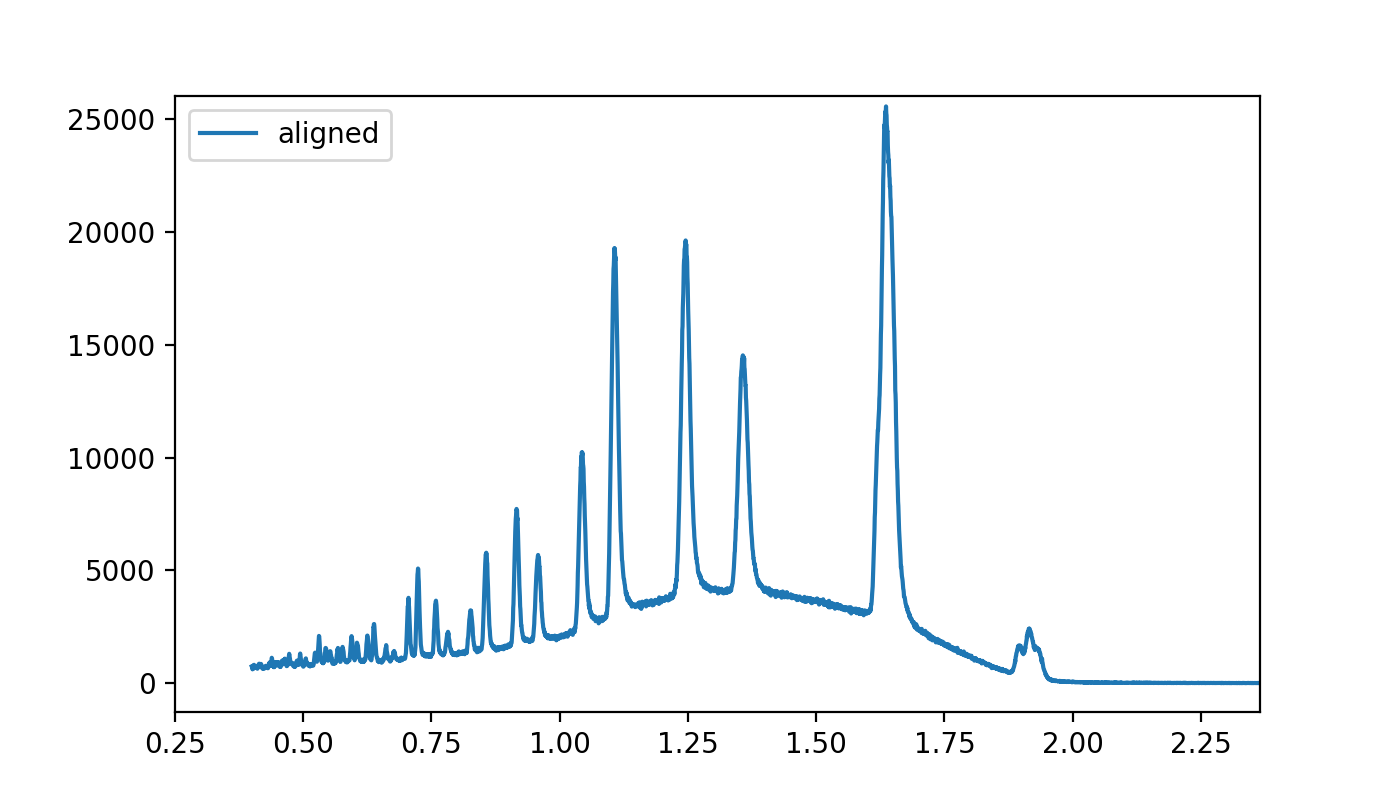

In [85]:
x_bb = I_d_pack_B9.readX(0); y = I_d_pack_B9.readY(0)
x = (x_bb[1:] + x_bb[:-1])/2
plt.figure(figsize=(7,4))
plt.plot(x,y, label='aligned')
# plt.xlim(3,3.3)
plt.legend(loc='upper left')

In [89]:
np.sum(mask[firstindex:lastindex+1])

5